In [1]:
import ast
import numpy as np
import time
import sys
import pandas as pd
import subprocess
import pickle
import random as rand
import matplotlib.pyplot as plt
import time
import math
import torch
from torch.utils.data.sampler import SubsetRandomSampler
import torch.nn as nn
import torch.nn.functional as F

In [2]:
from flt3_data_loading import km_normed_1, flt3_filtered

In [3]:
# Oversampling
# 132 positive, 320 negative => 320 positive, 320 negative
rand.seed(0)
positive_indices = [i for i in range(len(flt3_filtered)) if flt3_filtered[i] == 1]
new_positives = pd.DataFrame([[0.0 for j in range(km_normed_1.shape[1])] for i in range(320)])
new_positives.columns = km_normed_1.columns
for i in range(320):
    r = rand.randrange(0, len(positive_indices))
    new_positives.iloc[i] = km_normed_1.iloc[r]
    
# Combine with negative examples then shuffle
negatives = km_normed_1[np.array(flt3_filtered) == 0].set_index(new_positives.index.values)
over_combined = pd.concat([new_positives, negatives]).set_index(np.array(range(640)))
over_combined['label'] = np.array([1 for i in range(320)] + [0 for i in range(320)])
over_combined = over_combined.sample(frac=1, random_state=0).reset_index(drop=True)
oc_flt3 = over_combined.label
over_combined = over_combined.drop(['label'], axis=1)

In [4]:
# Data loading
num_workers = 0
batch_size = 64
valid_size = 0.2

data = []
for i in range(len(over_combined)):
    data.append([np.array(over_combined.iloc[i], dtype='f'), oc_flt3[i]])

num_train = len(over_combined)
indices = list(range(num_train))
np.random.shuffle(indices)
split = int(np.floor(valid_size * num_train))
train_idx, valid_idx = indices[split:], indices[:split]

train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

train_loader = torch.utils.data.DataLoader(data, batch_size=batch_size,
    sampler=train_sampler, num_workers=num_workers)
valid_loader = torch.utils.data.DataLoader(data, batch_size=batch_size, 
    sampler=valid_sampler, num_workers=num_workers)

In [42]:
# Model architecture
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(km_normed_1.shape[1], 2048)
        self.fc2 = nn.Linear(2048, 512)
        self.fc3 = nn.Linear(512, 128)
        self.fc4 = nn.Linear(128, 32)
        self.fc5 = nn.Linear(32, 8)
        self.fc6 = nn.Linear(8, 2)
    
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = F.relu(self.fc4(x))
        x = F.relu(self.fc5(x))
        x = self.fc6(x)
        return x
    
    def predict(self,x):
        pred = F.softmax(self.forward(x), dim=1)
        ans = []
        for t in pred:
            if t[0]>t[1]:
                ans.append(0)
            else:
                ans.append(1)
        return torch.tensor(ans)

Net(
  (fc1): Linear(in_features=3796, out_features=2048, bias=True)
  (fc2): Linear(in_features=2048, out_features=512, bias=True)
  (fc3): Linear(in_features=512, out_features=128, bias=True)
  (fc4): Linear(in_features=128, out_features=32, bias=True)
  (fc5): Linear(in_features=32, out_features=8, bias=True)
  (fc6): Linear(in_features=8, out_features=2, bias=True)
)


In [ ]:
%pdb

In [48]:
%%time
n_epochs = 1000
valid_loss_min = np.Inf
t_losses = []
v_losses = []

model = Net()
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)

for epoch in range(n_epochs):
    train_loss = 0.0
    valid_loss = 0.0
    
    # Training
    model.train()
    for data, target in train_loader:
        optimizer.zero_grad()
        output = model(data)
        target = target.long()
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        # update running training loss
        train_loss += loss.item()*data.size(0)
        
    # Validation
    model.eval()
    for data, target in valid_loader:
        output = model(data)
        target = target.long()
        loss = criterion(output, target)
        valid_loss += loss.item()*data.size(0)
        
    # Saving loss for validation graph
    train_loss = train_loss/len(train_loader.sampler)
    valid_loss = valid_loss/len(valid_loader.sampler)
    t_losses.append(train_loss)
    v_losses.append(valid_loss)
    
    # save model if validation loss has decreased
    if valid_loss < valid_loss_min:
        torch.save(model.state_dict(), 'model_files/model.pt')
        valid_loss_min = valid_loss
    
    # Progress bar
    print(f"\rEpoch: {epoch}\tTrain: {train_loss}\tVal: {valid_loss}\tMin Val: {valid_loss_min}", end='')
torch.save(model.state_dict(), 'model_files/model_final.pt')

Epoch: 3357	Train: 0.2293650321662426	Val: 1.1690707206726074	Min Val: 0.62054249644279488

KeyboardInterrupt: 

In [52]:
# Final model
model.load_state_dict(torch.load('model_files/model_final.pt'))
from sklearn.metrics import roc_auc_score
model.eval()
score = 0
for data, target in valid_loader:
    pred = model.predict(data)
    score += roc_auc_score(pred, target)
    print(pred)
    print(target)
print(score/(valid_size*10))

tensor([0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1,
        1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1])
tensor([0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1,
        1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1,
        0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1])
tensor([1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1,
        1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])
tensor([1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0,
        0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1,
        1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0])
0.7606725709151585


In [56]:
# Saved best model
model.load_state_dict(torch.load('model_files/model.pt'))
model.eval()
from sklearn.metrics import roc_auc_score
score = 0
for data, target in valid_loader:
    pred = model.predict(data)
    score += roc_auc_score(pred, target)
    print(pred)
    print(target)
print(score/(valid_size*10))

tensor([1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1,
        1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1,
        0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0])
tensor([1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1,
        1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1,
        0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0])
tensor([1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0,
        0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0,
        0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0])
tensor([1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1,
        0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0,
        1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1])
0.6379286268051563


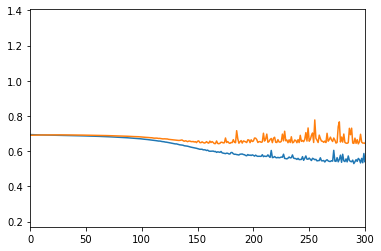

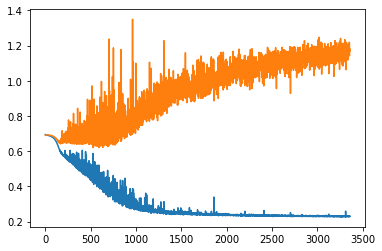

In [62]:
# Validation graph
plt.plot(t_losses)
plt.plot(v_losses)
plt.xlim(0, 300)
plt.show()

plt.plot(t_losses)
plt.plot(v_losses)
plt.show()